In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tinydb import TinyDB, Query
from tinydb.storages import MemoryStorage
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from pathlib import Path
import toml

Run = Query()
db = TinyDB(storage=MemoryStorage)


def load(base_dir):
    for log_dir in Path(base_dir).expanduser().glob('*'):
        if not log_dir.is_dir() or db.contains(Run.log_dir == str(log_dir)):
            continue
        print(f'Loading {log_dir}')
        evt_acc = EventAccumulator(str(next(log_dir.glob('events.*'))), purge_orphaned_data=False)
        evt_acc.Reload()

        config = toml.load(log_dir / 'config.toml')
        config['base_dir'] = str(base_dir)
        config['log_dir'] = str(log_dir)
        config['events'] = evt_acc
        
        db.insert(config)
    
def get_values(run, tag):
    timestamps, steps, values = zip(*run['events'].Scalars(tag))
    return np.array(values)

def get_steps(run, tag):
    timestamps, steps, values = zip(*run['events'].Scalars(tag))
    return np.array(steps)


In [16]:
import tinydb 
def unload(base_dir):
    for log_dir in Path(base_dir).expanduser().glob('*'):
        if not log_dir.is_dir() or not db.contains(Run.log_dir == str(log_dir)):
            continue
        db.remove(tinydb.where('log_dir') == str(log_dir))
        print('Removing', log_dir)
    


In [3]:
import torch

def effective_rank(mat):
    sigmas = np.linalg.svd(mat, compute_uv=False)
    x = sigmas / sigmas.sum()
    return np.exp(-np.sum(x * np.log(x + 1e-10)))


def plot_with_std(ax, xs, ys, color, alpha=0.3, shade=False, **kwargs):
    ys = np.array(ys)
    mean = np.array([np.mean(t) for t in ys])
    std = np.array([np.std(t) for t in ys])
    if shade:
        kwargs['alpha'] = 0.3
#     ax.fill_between(xs, mean - std, mean + std, color=color, alpha=alpha)
    ax.errorbar(xs, mean, yerr=std, color=color)
    return ax.semilogx(xs, mean, color, **kwargs)[0]


In [24]:
load('/tmp/exp1')  # 2k5
load('/tmp/exp2')  # 2k5


Loading /u/yupingl/logs/old-mat-cmpl-cvx-2k/0


# Figure 1

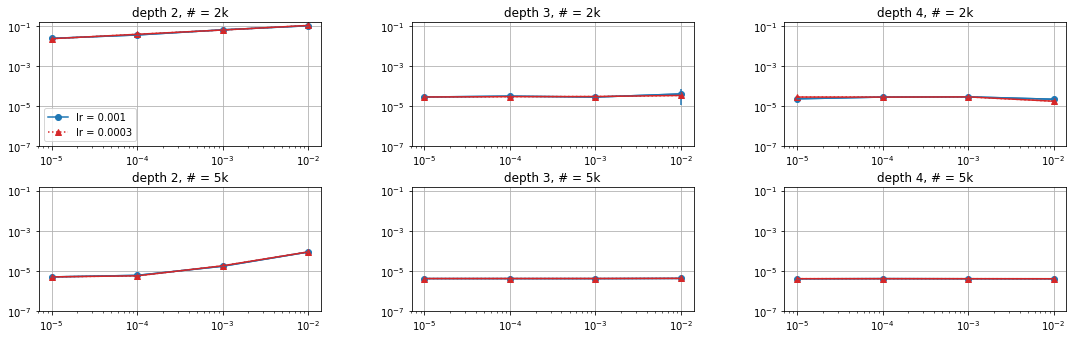

In [33]:

plt.rcParams.update({'axes.formatter.limits': (-4, 4)})

import os.path

fig, axes = plt.subplots(2, 3, figsize=(15, 4.6 * 1.0))
fig.tight_layout(w_pad=6, h_pad=2)


init_scales = [1e-3, 1e-4, 1e-5, 1e-6]

dataset_info = {
    'datasets/mat-cmpl/2000.pt': {
        'name': '# = 2k',
        'lrs': [0.001, 0.0003],
    },
    'datasets/mat-cmpl/5000.pt': {
        'name': '# = 5k',
        'lrs': [0.001, 0.0003],
    },
}


for idx_dataset, dataset in enumerate(['datasets/mat-cmpl/2000.pt', 'datasets/mat-cmpl/5000.pt']):
    for idx_depth, depth in enumerate([2, 3, 4]):
        ax = axes[idx_dataset, idx_depth]
        lrs = [0.001, 0.0003]
        for lr in lrs:
            xs = []
            train_errors = []
            test_errors = []

            for init_scale in init_scales:
                runs = db.search((Run.lr == lr) & (Run.obs_path == dataset) & (Run.init_scale == init_scale) & (Run.depth == depth))

                test_errors.append([])
                train_errors.append([])
                for run in runs:
                    test_errors[-1].append(get_values(run, 'loss/test')[-1])
                    train_errors[-1].append(get_values(run, 'loss/train')[-1])
                xs.append(init_scale * 10)

            if len(xs):
                if lr == lrs[0]:
                    plot_with_std(ax, xs, test_errors, 'C0', label=f'lr = 0.001', marker='o')
                else:
                    plot_with_std(ax, xs, test_errors, 'C3', ls=':', label='lr = 0.0003', marker='^')

        
        w_gt = torch.load('./datasets/mat-cmpl/gt.pt', map_location='cpu')            
                    
        ax.set_yscale('log')
        ax.set_title(f'depth {depth}, {dataset_info[dataset]["name"]}')

        ax.set_ylim(1e-7, 0.15)
        if idx_dataset == 0 and idx_depth == 0:
            ax.legend()
        ax.grid()


# Figure 2

datasets/mat-cmpl/100-5-2000-obs.pt 210.15163
datasets/mat-cmpl/5000.pt 221.02568


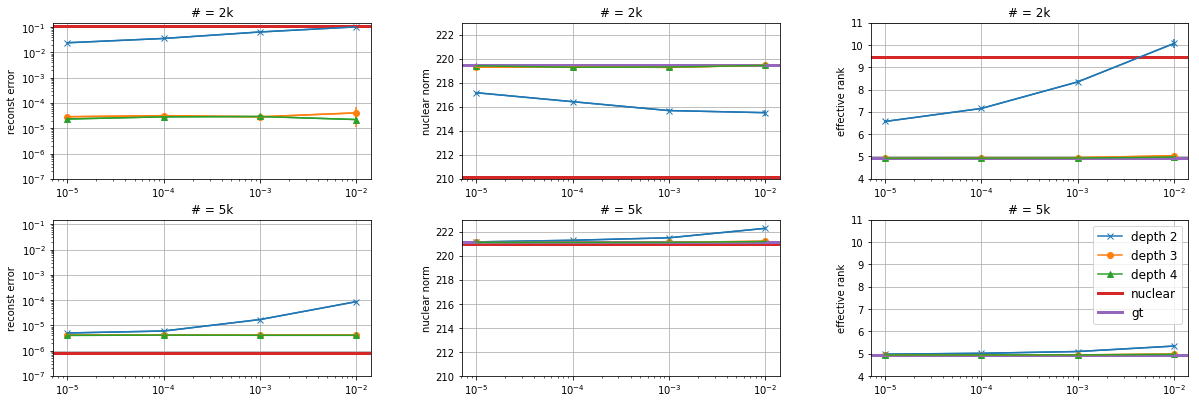

In [153]:
import os.path
import torch


fig, axes = plt.subplots(2, 3, figsize=(16.5, 5.5 * 1.0))
fig.tight_layout(w_pad=6, h_pad=2)

axes = axes.T
from pathlib import Path

init_scales = [1e-3, 1e-4, 1e-5, 1e-6]

datasets = [
    ['datasets/mat-cmpl/2000.pt', '# = 2k'],
    ['datasets/mat-cmpl/5000.pt', '# = 5k'],
]

legends = {}

for idx_dataset, (dataset, ds_name) in enumerate(datasets):
    lrs = [0.001]
    for lr in lrs:
        for depth in [2, 3, 4]:
            xs = []
            train_errors = []
            test_errors = []
            nuclear_norms = []
            eranks = []

            for init_scale in init_scales:
                runs = db.search((Run.lr == lr) & (Run.obs_path == dataset) & (Run.init_scale == init_scale) & (Run.depth == depth))
                test_errors.append([])
                train_errors.append([])
                nuclear_norms.append([])
                eranks.append([])
                for run in runs:
                    sol = torch.load(str(Path(run['log_dir']) / 'final.npy'), map_location='cpu').cpu().detach().numpy()
                    test_errors[-1].append(get_values(run, 'loss/test')[-1])
                    train_errors[-1].append(get_values(run, 'loss/train')[-1])
                    nuclear_norms[-1].append(np.linalg.norm(sol, 'nuc'))
                    eranks[-1].append(effective_rank(sol))
                xs.append(init_scale * 10)

            if len(xs):
                alpha = 1. if lr == 0.003 else 0.5
                kwargs = {}
                if lr == lrs[0]:
                    kwargs['label'] = f'depth {depth}'
                marker = "xo^"[depth - 2]
#                 print(test_errors)
                
                legends[f'depth {depth}'] = plot_with_std(axes[0, idx_dataset], xs, test_errors, f'C{depth - 2}', marker=marker, **kwargs)
                legends[f'depth {depth}'] = plot_with_std(axes[1, idx_dataset], xs, nuclear_norms, f'C{depth - 2}', marker=marker, **kwargs)
                legends[f'depth {depth}'] = plot_with_std(axes[2, idx_dataset], xs, eranks, f'C{depth - 2}', marker=marker, **kwargs)

    w_gt = torch.load('./datasets/mat-cmpl/gt.pt', map_location='cpu')
    (us, vs), ys_ = torch.load(os.path.expanduser(dataset), map_location='cpu')
    trivial = torch.zeros_like(w_gt)
    trivial[us, vs] = ys_

    cvx_run = db.search((Run.obs_path == dataset) & (Run.optimizer == 'cvxpy'))[0]
    cvx_sol = torch.load(str(Path(cvx_run['log_dir']) / 'nuclear.npy'))
    print(dataset, np.linalg.norm(cvx_sol, 'nuc'))

    ax = axes[0, idx_dataset]
    ax.axhline(get_values(cvx_run, 'loss/test')[-1], label='nuclear', color='C3', linewidth=3.0)
    ax.set_title('reconst error')
    ax.set_ylabel('reconst error')
    ax.set_ylim(1e-7, 0.15)
    ax.set_yscale('log')

    ax = axes[1, idx_dataset]
    legends['nuclear'] = ax.axhline(np.linalg.norm(cvx_sol, 'nuc'), label='nuclear', color='C3', linewidth=3.0)
    ax.axhline(np.linalg.norm(w_gt, 'nuc'), label='gt', color='C4', linewidth=3.0)
    ax.set_ylabel('nuclear norm')
    ax.set_title('nuclear norm')
    ax.set_ylim(210, 223)

    ax = axes[2, idx_dataset]
    ax.axhline(effective_rank(cvx_sol), label='cvx opt', color='C3', linewidth=3.0)
    legends['gt'] = ax.axhline(effective_rank(w_gt), label='gt', color='C4', linewidth=3.0)
    ax.set_ylabel('effective rank')
    ax.set_ylim(4, 11)

    for i in range(3):
        ax = axes[i, idx_dataset]
        ax.grid()
        ax.set_title(f'{ds_name}')

axes[2, 1].legend(legends.values(), legends.keys(), prop={'size': 12})



# Figure 3

1 datasets/mat-cmpl/2000.pt 0.001 0.8195478320121765
2 datasets/mat-cmpl/2000.pt 0.001 0.0988251343369484
3 datasets/mat-cmpl/2000.pt 0.001 0.0016706569585949183
1 datasets/ml-100k/ml-100k.pkl 0.001 13.728069305419922
2 datasets/ml-100k/ml-100k.pkl 0.001 1.4497840404510498
3 datasets/ml-100k/ml-100k.pkl 0.001 1.397607445716858


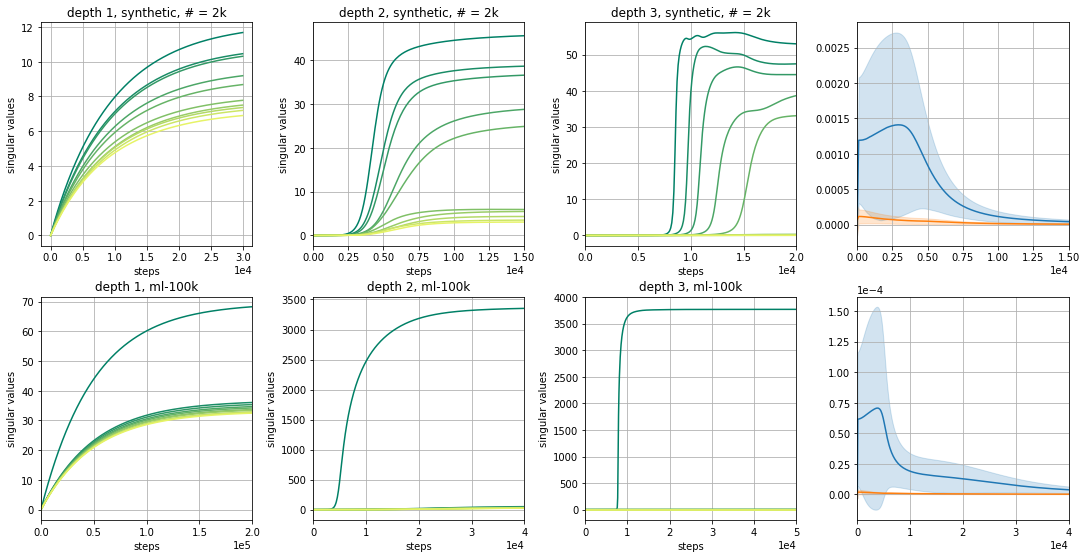

In [32]:
import os.path


fig, axes = plt.subplots(2, 4, figsize=(15, 5 * 1.5))
fig.tight_layout(w_pad=3, h_pad=3)


def plot_alignment(ax, run):
    diag_mean = get_values(run, 'diag/mean')
    diag_std = get_values(run, 'diag/std')
    off_diag_mean = get_values(run, 'off_diag/mean')
    off_diag_std = get_values(run, 'off_diag/std')
    xs = get_steps(run, 'off_diag/std')

    ax.plot(xs, diag_mean, color='C0', label='diagonal')
    ax.fill_between(xs, diag_mean - diag_std, diag_mean + diag_std, color='C0', alpha=0.2)
    ax.plot(xs, off_diag_mean, color='C1', label='off diagonal')
    ax.fill_between(xs, off_diag_mean - off_diag_std, off_diag_mean + off_diag_std, color='C1', alpha=0.2)
    
    if lr == 0.1:
        ax.legend()
        ax.grid()
        ax.set_title(r'$U^\top \nabla W V$ on depth-2 net')


for id_dataset, (dataset, name) in enumerate([('datasets/mat-cmpl/2000.pt', 'synthetic, # = 2k'), ('datasets/ml-100k/ml-100k.pkl', 'ml-100k')]):
    for id_depth, depth in enumerate([1, 2, 3]):
        ax = axes[id_dataset, id_depth]

        run = db.search((Run.n_singulars_save == 10) & (Run.obs_path == dataset) & (Run.depth == depth))
        if not run:
            continue
        run = run[0]

        print(depth, dataset, lr, np.min(get_values(run, 'loss/test')))
        xs = get_steps(run, 'singular_values/0')

        alpha = 1.

        for i in range(10):
            ax.plot(xs, get_values(run, f'singular_values/{i}'), color=plt.cm.summer(i / 10), alpha=alpha)

        if depth == 2:
            plot_alignment(axes[id_dataset, 3], run)
            if id_dataset == 0:
                axes[id_dataset, 3].set_xlim(0, 15000)
            else:
                axes[id_dataset, 3].set_xlim(0, 40000)
        if depth == 3 and id_dataset == 0:
            ax.set_xlim(0, 20000)
        if depth == 2 and id_dataset == 0:
            ax.set_xlim(0, 15000)
        if depth == 1 and id_dataset == 1:
            ax.set_xlim(0, 200000)
        if depth == 2 and id_dataset == 1:
            ax.set_xlim(0, 40000)
        if depth == 3 and id_dataset == 1:
            ax.set_xlim(0, 50000)

        ax.set_ylabel('singular values')

        ax.grid()
        ax.set_xlabel('steps')
        
        ax.set_title(f'depth {depth}, {name}')
    axes[id_dataset, 3].grid()

# Appendix Figure 1

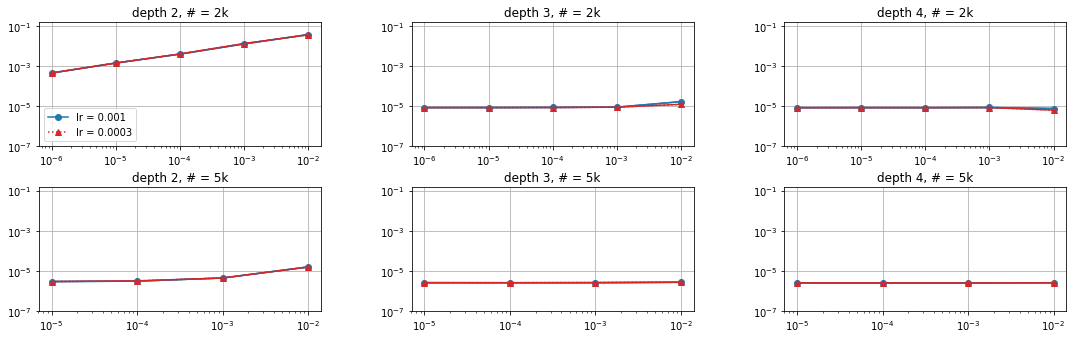

In [11]:

plt.rcParams.update({'axes.formatter.limits': (-4, 4)})

import os.path

fig, axes = plt.subplots(2, 3, figsize=(15, 4.6 * 1.0))
fig.tight_layout(w_pad=6, h_pad=2)


init_scales = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7]

dataset_info = {
    'datasets/mat-sensing/2000.pt': {
        'name': '# = 2k5',
        'lrs': [0.001, 0.0003],
    },
    'datasets/mat-sensing/5000.pt': {
        'name': '# = 5k',
        'lrs': [0.001, 0.0003],
    },
}


for idx_dataset, dataset in enumerate(['datasets/mat-sensing/2000.pt', 'datasets/mat-sensing/5000.pt']):
    for idx_depth, depth in enumerate([2, 3, 4]):
        ax = axes[idx_dataset, idx_depth]
        lrs = [0.001, 0.0003]
        for lr in lrs:
            xs = []
            train_errors = []
            test_errors = []

            for init_scale in init_scales:
                runs = db.search((Run.lr == lr) & (Run.obs_path == dataset) & (Run.init_scale == init_scale) & (Run.depth == depth))

                test_errors.append([])
                train_errors.append([])
                for run in runs:
                    test_errors[-1].append(get_values(run, 'loss/test')[-1])
                    train_errors[-1].append(get_values(run, 'loss/train')[-1])
                xs.append(init_scale * 10)

            if len(xs):
#                 print(depth, lr, init_scale, test_errors)
                if lr == lrs[0]:
                    plot_with_std(ax, xs, test_errors, 'C0', label=f'lr = 0.001', marker='o')
                else:
                    plot_with_std(ax, xs, test_errors, 'C3', ls=':', label='lr = 0.0003', marker='^')


        w_gt = torch.load('./datasets/mat-sensing/gt.pt', map_location='cpu')

        ax.set_yscale('log')
        ax.set_title(f'depth {depth}, {dataset_info[dataset]["name"]}')

        ax.set_ylim(1e-7, 0.15)
        if idx_dataset == 0 and idx_depth == 0:
            ax.legend()
        ax.grid()


# Appendix Figure 2

datasets/mat-sensing/100-5-2k-obs.pt 220.09865
datasets/mat-sensing/5000.pt 221.03319


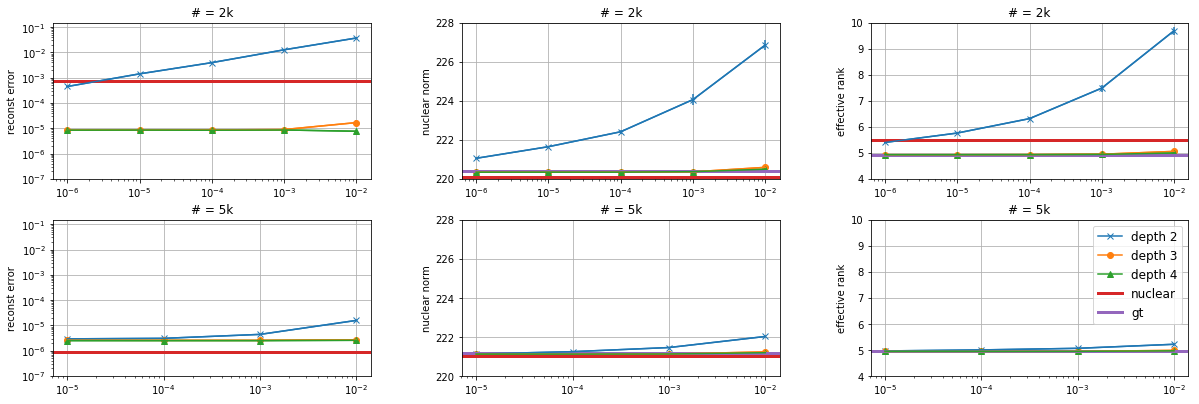

In [12]:
import os.path
import torch


fig, axes = plt.subplots(2, 3, figsize=(16.5, 5.5 * 1.0))
fig.tight_layout(w_pad=6, h_pad=2)

axes = axes.T
from pathlib import Path

init_scales = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7]

datasets = [
    ['datasets/mat-sensing/100-5-2k-obs.pt', '# = 2k'],
#     ['datasets/mat-sensing/2500.pt', '# = 2k5'],
    ['datasets/mat-sensing/5000.pt', '# = 5k'],
]

legends = {}

for idx_dataset, (dataset, ds_name) in enumerate(datasets):
    lrs = [0.001]
    for lr in lrs:
        for depth in [2, 3, 4]:
            xs = []
            train_errors = []
            test_errors = []
            nuclear_norms = []
            eranks = []

            for init_scale in init_scales:
                runs = db.search((Run.lr == lr) & (Run.obs_path == dataset) & (Run.init_scale == init_scale) & (Run.depth == depth))
                test_errors.append([])
                train_errors.append([])
                nuclear_norms.append([])
                eranks.append([])
                for run in runs:
                    sol = torch.load(str(Path(run['log_dir']) / 'final.npy'), map_location='cpu').cpu().detach().numpy()
                    test_errors[-1].append(get_values(run, 'loss/test')[-1])
                    train_errors[-1].append(get_values(run, 'loss/train')[-1])
                    nuclear_norms[-1].append(np.linalg.norm(sol, 'nuc'))
                    eranks[-1].append(effective_rank(sol))
                xs.append(init_scale * 10)

            if len(xs):
                alpha = 1. if lr == 0.003 else 0.5
                kwargs = {}
                if lr == lrs[0]:
                    kwargs['label'] = f'depth {depth}'
                marker = "xo^"[depth - 2]
#                 print(test_errors)
                
                legends[f'depth {depth}'] = plot_with_std(axes[0, idx_dataset], xs, test_errors, f'C{depth - 2}', marker=marker, **kwargs)
                legends[f'depth {depth}'] = plot_with_std(axes[1, idx_dataset], xs, nuclear_norms, f'C{depth - 2}', marker=marker, **kwargs)
                legends[f'depth {depth}'] = plot_with_std(axes[2, idx_dataset], xs, eranks, f'C{depth - 2}', marker=marker, **kwargs)

    w_gt = torch.load('./datasets/mat-sensing/gt.pt', map_location='cpu')

    cvx_run = db.search((Run.obs_path == dataset) & (Run.optimizer == 'cvxpy'))[0]
    cvx_sol = torch.load(str(Path(cvx_run['log_dir']) / 'nuclear.npy'))
    print(dataset, np.linalg.norm(cvx_sol, 'nuc'))

    ax = axes[0, idx_dataset]
    ax.axhline(get_values(cvx_run, 'loss/test')[-1], label='nuclear', color='C3', linewidth=3.0)
    ax.set_title('reconst error')
    ax.set_ylabel('reconst error')
    ax.set_ylim(1e-7, 0.15)
    ax.set_yscale('log')

    ax = axes[1, idx_dataset]
    legends['nuclear'] = ax.axhline(np.linalg.norm(cvx_sol, 'nuc'), label='nuclear', color='C3', linewidth=3.0)
    ax.axhline(np.linalg.norm(w_gt, 'nuc'), label='gt', color='C4', linewidth=3.0)
    ax.set_ylabel('nuclear norm')
    ax.set_title('nuclear norm')
    ax.set_ylim(220, 228)

    ax = axes[2, idx_dataset]
    ax.axhline(effective_rank(cvx_sol), label='cvx opt', color='C3', linewidth=3.0)
    legends['gt'] = ax.axhline(effective_rank(w_gt), label='gt', color='C4', linewidth=3.0)
    ax.set_ylabel('effective rank')
    ax.set_ylim(4, 10)

    for i in range(3):
        ax = axes[i, idx_dataset]
        ax.grid()
        ax.set_title(f'{ds_name}')

axes[2, 1].legend(legends.values(), legends.keys(), prop={'size': 12})
